## Imports

In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import mne

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Load dataset

In [2]:
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

## Phase-Amplitude Coupling

The comodulogram is a matrix representing the strength of the coupling between the phase of driver frequencies and the amplitude of signal frequencies. The 'pac' method allows to extract pairs of driver/signal frequencies that exhibit higher scores of coupling

[[4.7, 26.0], [6.300000000000001, 24.0], [6.1, 8.0], [6.2, 17.0], [6.5, 27.0], [6.5, 26.0], [6.2, 18.0], [6.5, 24.0], [6.0, 18.0], [6.5, 23.0], [6.1, 9.0], [6.0, 17.0], [5.9, 43.0], [5.9, 44.0], [5.9, 45.0], [4.7, 25.0], [6.2, 26.0], [6.6, 27.0], [6.6, 26.0], [4.8, 29.0], [6.1, 10.0], [4.8, 28.0], [6.300000000000001, 25.0], [6.2, 19.0], [6.2, 16.0], [5.9, 46.0], [4.7, 28.0], [6.4, 24.0], [4.7, 27.0], [6.1, 11.0]]


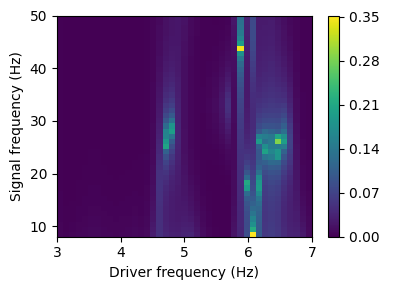

In [8]:
biotuning = compute_biotuner(1000, data = data[10], peaks_function = 'harmonic_recurrence', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = False, ratios_inc = True, scale_cons_limit = 0.1) # Initialize biotuner object
pac_freqs, _ = biotuning.pac(n_values = 30, plot=True, drive_precision = 0.1, max_drive_freq = 7, method = 'duprelatour')
print(pac_freqs)

Different methods can be used to compute the PAC:
methods = ['ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum']

[[4.3, 39.0],
 [3.4, 20.0],
 [4.3, 49.0],
 [3.4, 47.0],
 [4.3, 40.0],
 [3.4, 48.0],
 [3.3, 45.0],
 [4.3, 41.0],
 [4.1, 42.0],
 [4.1, 8.0]]

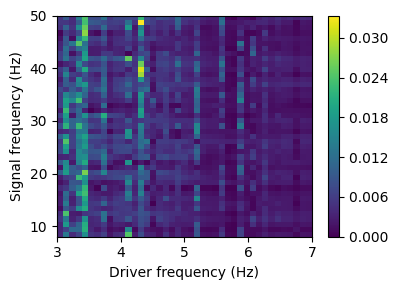

In [9]:
pac_freqs, _ = biotuning.pac(plot=True, drive_precision = 0.1, n_values = 10, max_drive_freq = 7, method = 'ozkurt')
pac_freqs

## Deriving tunings from PAC information

By computing the most frequent phase and amplitude frequencies from the 'pac_freqs' lists, we can derive a series of ratios by coupling each phase with each amplitude frequencies

In [10]:
pac_frequent = pairs_most_frequent(pac_freqs, 3)
pac_frequent

[[8.0, 42.0, 41.0], [4.3, 3.4, 4.1]]

In [6]:
ratios = []
for i in range(len(pac_frequent[0])):
    for j in range(len(pac_frequent[1])):
        ratios.append(rebound(pac_frequent[0][i]/pac_frequent[1][j]))
        
ratios = sorted(ratios)
ratios

[1.1764705882352942,
 1.1918604651162792,
 1.2209302325581395,
 1.25,
 1.2804878048780488,
 1.5073529411764706,
 1.5441176470588236,
 1.8604651162790697,
 1.9512195121951221]

Another approach to derive tuning based on the information of the Phase-Amplitude Coupling would be to compute the ratios of each pairs of phase/amplitude frequencies, and then to apply the 'scale_reduction' function to extract the most consonant intervals. This is what the pac_mode function does.

In [13]:
from biotuner.scale_construction import pac_mode
pac_mode(pac_freqs, n=6, function=dyad_similarity)

[1.1337209302325582,
 1.1627906976744187,
 1.1918604651162792,
 1.4244186046511629,
 1.4705882352941178,
 1.7647058823529411]

In [14]:
pac_mode(pac_freqs, n=10)

[1.1337209302325582,
 1.1627906976744187,
 1.1918604651162792,
 1.2804878048780488,
 1.4244186046511629,
 1.4705882352941178,
 1.7045454545454546,
 1.7279411764705883,
 1.7647058823529411,
 1.9512195121951221]

### Using coupled frequencies as generator interval

This code analyzes phase amplitude coupling (PAC) and constructs a musical scale based on the frequency ratios associated with the PAC. 

First, the code calculates the frequency ratio between the two oscillatory signals that exhibit PAC, stored in the `pac_freqs` variable. The frequency ratio is then converted to a rational number using the `sp.Rational()` function and its denominator is limited to 1000 using `.limit_denominator()`. 

Next, the code generates the Stern-Brocot interval associated with the rational number using `gen_interval_to_stern_brocot()`. The interval represents a sequence of fractions that converge to the rational number and is used to determine the generator interval tuning. A generator interval is a specific type of musical interval that can be used to generate a scale. 

The number of steps in the interval is limited to 16 using `.limit_denominator()`, and the generator interval tuning is calculated based on the interval and number of steps using `generator_interval_tuning()`. The resulting `gen_int_tuning` variable contains the musical scale based on the PAC frequency ratio, with `limit_steps` number of steps in the scale and an octave of 2. The tuning is generated by sorting the generator interval tuning in ascending order using `sorted()`.


In [22]:
# Import the necessary functions from the biotuner.scale_construction module
from biotuner.scale_construction import gen_interval_to_stern_brocot, generator_interval_tuning

# Calculate the frequency ratio between the two oscillatory signals that exhibit phase amplitude coupling (stored in pac_freqs variable) and convert it to a rational number with a denominator limited to 1000
ratio = rebound(pac_freqs[0][1]/pac_freqs[0][0])
print(sp.Rational(ratio).limit_denominator(1000))

# Set the limit on the number of steps in the interval to 16 and generate the Stern-Brocot interval based on the frequency ratio
limit_steps = 16
stern_brocot_ratio = gen_interval_to_stern_brocot(ratio)

# Limit the number of steps in the interval to 16 and calculate the steps needed for the generator interval tuning
steps = Fraction(stern_brocot_ratio).limit_denominator(16).denominator

# Calculate the generator interval tuning based on the interval and number of steps, and sort the tuning in ascending order
gen_int_tuning = sorted(generator_interval_tuning(interval = ratio, steps = steps, octave = 2))

# Store the resulting musical scale in the gen_int_tuning variable
gen_int_tuning


195/172


[1.0,
 1.0617126480059673,
 1.1337209302325582,
 1.2036858509369976,
 1.285323147647377,
 1.3646438426320615,
 1.457197754600224,
 1.5471252867049534,
 1.652055593878161,
 1.7540083192294529,
 1.8729700046874498]

## Deriving euclidian rhythms from PAC information

This code constructs a musical scale based on the phase amplitude coupling (PAC) frequencies and uses it to generate a consonant rhythmic pattern. The PAC scale is generated using the pac_mode() function and the consonant rhythmic pattern is generated using the consonant_euclid() function. The resulting rhythm is represented as a list of strings and can be played using the Euclidean rhythm. This code could be useful for creating music that is based on the natural rhythms of biological systems

In [24]:
# Import the necessary dictionaries and functions from the biotuner module
from biotuner.dictionaries import *
from biotuner.rhythm_construction import *

# Generate a musical scale based on the phase amplitude coupling (PAC) frequencies using the pac_mode() function
pac_scale = pac_mode(pac_freqs, 10, function=dyad_similarity)

# Generate a consonant Euclidean rhythm based on the PAC scale using the consonant_euclid() function
euclid_final, cons = consonant_euclid(pac_scale, n_steps_down = 3, limit_denom = 4, 
                                      limit_cons =1, limit_denom_final = 100)

# Generate a list of interval vectors based on the Euclidean rhythm
interval_vectors = [interval_vector(x) for x in euclid_final]

# Convert the list of interval vectors to a list of strings using the interval_vec_to_string() function
strings = interval_vec_to_string(interval_vectors)

# Convert the rhythmic pattern strings to their corresponding reference rhythms based on the dict_rhythms dictionary using the euclid_string_to_referent() function
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)

# Store the resulting Euclidean rhythm, interval vectors, and reference rhythms in the euclid_final, interval_vectors, and euclid_referent variables, respectively
euclid_final, interval_vectors, euclid_referent


([[1, 0, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0],
  [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 1, 0],
  [1, 1, 0],
  [1, 1, 0, 1, 1, 0],
  [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]],
 [[3],
  [4],
  [4, 4],
  [4, 4, 4],
  [3, 3],
  [3, 3, 3, 3],
  [2, 2, 2],
  [2, 2, 2, 2],
  [1, 2],
  [1, 2, 1, 2],
  [1, 2, 1, 2, 1, 2, 1, 2]],
 ['None',
  'None',
  'None',
  'None',
  'None',
  'It is periodic with four repetitions of E(1,3) = [100]. It is the (12/8)-time Fandago clapping pattern in the Flamenco music of southern Spain, where 1 denotes a loud clap and 0 soft clap.',
  'None',
  'None',
  'A common Afro-Cuban drum pattern when started on the second onset as in [101]. For example, it is the conga rhythm of the (6/8)-time Swing Tumbao. It is common in Latin American music, as for example in the Cueca, and the coros de clave. It is common in Arabic music, as for example in the Al Taer rhy